# Homework 4: Evaluation Metrics for Classification

Dataset: https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

Main: https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2024/04-evaluation/homework.md

In [ ]:
import pandas as pd
df = pd.read_csv('/content/bank-full.csv', sep=';')

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
X=df.drop(['y', 'default', 'loan'],axis=1)
y=df['y']

In [ ]:
df.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [ ]:
from sklearn.model_selection import train_test_split

SEED = 1

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

assert len(df) == (len(df_train) + len(df_val) + len(df_test))

In [ ]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [ ]:
from sklearn.metrics import roc_auc_score

numerical_columns = ['balance', 'day', 'duration', 'previous']

auc_scores = {}

for col in numerical_columns:
    auc = roc_auc_score(y_train, df_train[col])

    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])

    auc_scores[col] = auc
    print(f"AUC for {col}: {auc}")

best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nNumerical variable with the highest AUC: {best_feature} (AUC = {auc_scores[best_feature]})")

AUC for balance: 0.5888313805382317
AUC for day: 0.525957882383908
AUC for duration: 0.8147002759670778
AUC for previous: 0.5985653242764153

Numerical variable with the highest AUC: duration (AUC = 0.8147002759670778)


In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dicts = df_train.drop(columns=['y']).to_dict(orient='records')
val_dicts = df_val.drop(columns=['y']).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_val_pred = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_val_pred)
print(f"AUC on validation set: {auc:.3f}")

AUC on validation set: 0.901


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


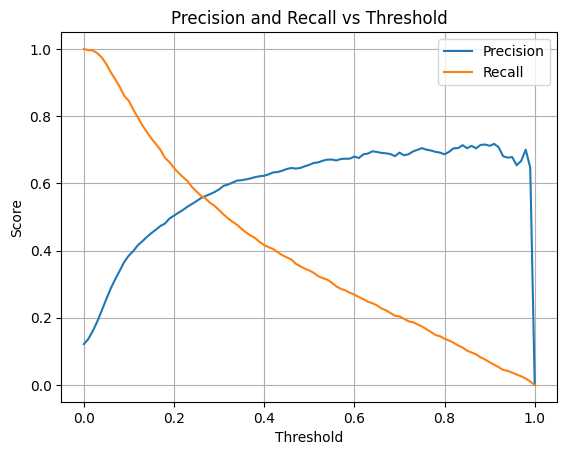

Precision and Recall intersect at threshold: 0.260


In [ ]:
df_train['y'] = df_train['y'].map({'no': 0, 'yes': 1})
df_val['y'] = df_val['y'].map({'no': 0, 'yes': 1})
df_test['y'] = df_test['y'].map({'no': 0, 'yes': 1})

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values


precisions = []
recalls = []
thresholds = np.arange(0.0, 1.01, 0.01)

for threshold in thresholds:
    y_val_pred = (y_val_pred_proba >= threshold).astype(int)
    precisions.append(precision_score(y_val, y_val_pred))
    recalls.append(recall_score(y_val, y_val_pred))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

for i in range(len(thresholds)):
    if np.isclose(precisions[i], recalls[i], atol=0.01):
        print(f"Precision and Recall intersect at threshold: {thresholds[i]:.3f}")
        break

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


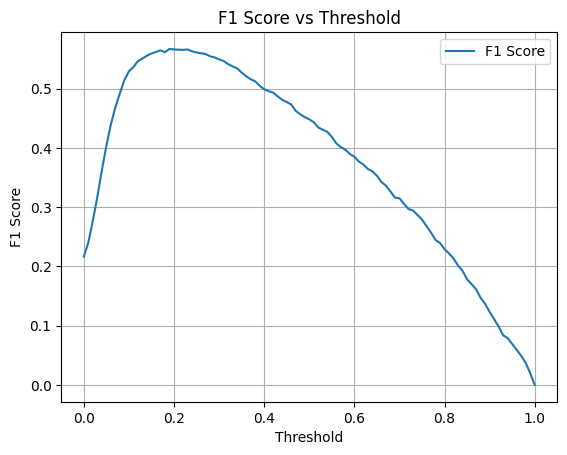

Threshold with the maximum F1 score: 0.19


In [ ]:
from sklearn.metrics import precision_score, recall_score

f1_scores = []
thresholds = np.arange(0.0, 1.01, 0.01)

for threshold in thresholds:
    y_val_pred = (y_val_pred_proba >= threshold).astype(int)

    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    f1_scores.append(f1)

plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Threshold with the maximum F1 score: {best_threshold:.2f}")

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

auc_scores = []

for train_index, val_index in kf.split(df_full_train):
    df_train_cv = df_full_train.iloc[train_index]
    df_val_cv = df_full_train.iloc[val_index]

    train_dicts = df_train_cv.drop(columns=['y']).to_dict(orient='records')
    val_dicts = df_val_cv.drop(columns=['y']).to_dict(orient='records')

    y_train_cv = df_train_cv['y'].map({'no': 0, 'yes': 1}).values
    y_val_cv = df_val_cv['y'].map({'no': 0, 'yes': 1}).values

    dv = DictVectorizer(sparse=False)
    X_train_cv = dv.fit_transform(train_dicts)
    X_val_cv = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_cv, y_train_cv)

    y_val_pred_proba_cv = model.predict_proba(X_val_cv)[:, 1]

    auc_cv = roc_auc_score(y_val_cv, y_val_pred_proba_cv)
    auc_scores.append(auc_cv)

    print(f"AUC for this fold: {auc_cv:.4f}")

std_auc = np.std(auc_scores)
print(f"\nStandard deviation of AUC scores across folds: {std_auc:.4f}")

AUC for this fold: 0.8999
AUC for this fold: 0.9011
AUC for this fold: 0.9117
AUC for this fold: 0.9087
AUC for this fold: 0.9129

Standard deviation of AUC scores across folds: 0.0054


In [ ]:
C_values = [0.000001, 0.001, 1]

results = {}

for C in C_values:
    auc_scores = []

    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

    for train_index, val_index in kf.split(df_full_train):
        df_train_cv = df_full_train.iloc[train_index]
        df_val_cv = df_full_train.iloc[val_index]

        train_dicts = df_train_cv.drop(columns=['y']).to_dict(orient='records')
        val_dicts = df_val_cv.drop(columns=['y']).to_dict(orient='records')

        y_train_cv = df_train_cv['y'].map({'no': 0, 'yes': 1}).values
        y_val_cv = df_val_cv['y'].map({'no': 0, 'yes': 1}).values

        dv = DictVectorizer(sparse=False)
        X_train_cv = dv.fit_transform(train_dicts)
        X_val_cv = dv.transform(val_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_cv, y_train_cv)

        y_val_pred_proba_cv = model.predict_proba(X_val_cv)[:, 1]

        auc_cv = roc_auc_score(y_val_cv, y_val_pred_proba_cv)
        auc_scores.append(auc_cv)

    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    results[C] = (mean_auc, std_auc)
    print(f"C = {C}: mean AUC = {mean_auc:.3f}, std = {std_auc:.3f}")

best_C = sorted(results.items(), key=lambda x: (-x[1][0], x[1][1], x[0]))[0][0]
best_mean_auc, best_std_auc = results[best_C]

print(f"\nBest C: {best_C} with mean AUC = {best_mean_auc:.3f} and std = {best_std_auc:.3f}")

C = 1e-06: mean AUC = 0.702, std = 0.009
C = 0.001: mean AUC = 0.865, std = 0.007
C = 1: mean AUC = 0.907, std = 0.005

Best C: 1 with mean AUC = 0.907 and std = 0.005
